# Sprint データセット作成

## 【問題1】自作データセットでの分類の学習
自作のデータセットに対して分類問題を解いてください。任意の実装を使用してください。

In [152]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import time

from IPython import display

In [466]:
# 犬猫画像を読み込み、ndarrayに変換
# 画像はネットから拾ったもの
dataset = []
target = []

BASE_PATH = '/Users/tamiyagt/Documents/Machine Learning/01_github/diveintocode-ml/sprint/sprint18_dataset/train/'
for i, image in enumerate(os.listdir(BASE_PATH)):
    if '.jpg' in image:
        im = PIL.Image.open(BASE_PATH+image)
        im_rgb = im.convert('RGB')
        dataset.append(im_rgb)
        
        # 正解ラベル配列を作成
        if 'cat' in image: target.append(0)
        if 'dog' in image: target.append(1)

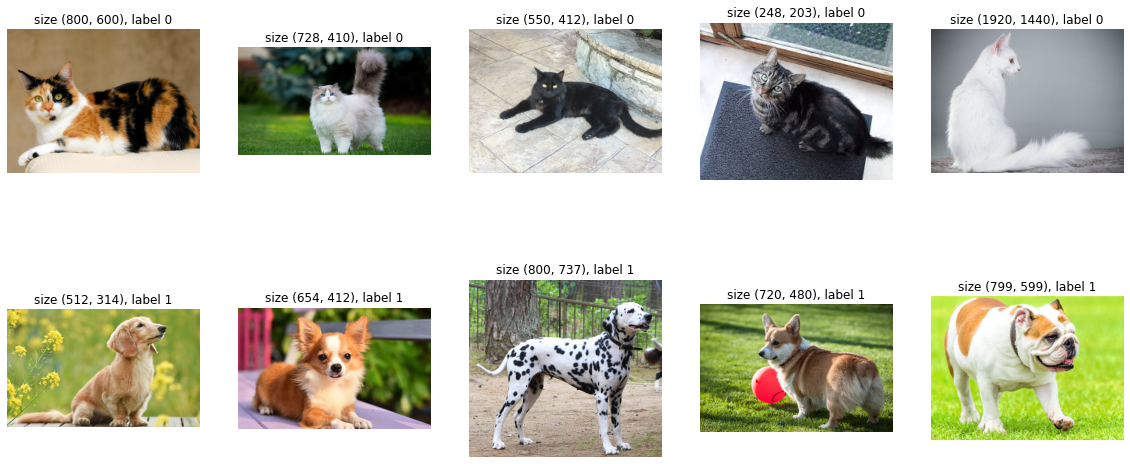

In [334]:
fig = plt.figure(figsize=(20,9))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(dataset[i])
    plt.axis('off')
    plt.title('size {}, label {}'.format(dataset[i].size, target[i]))

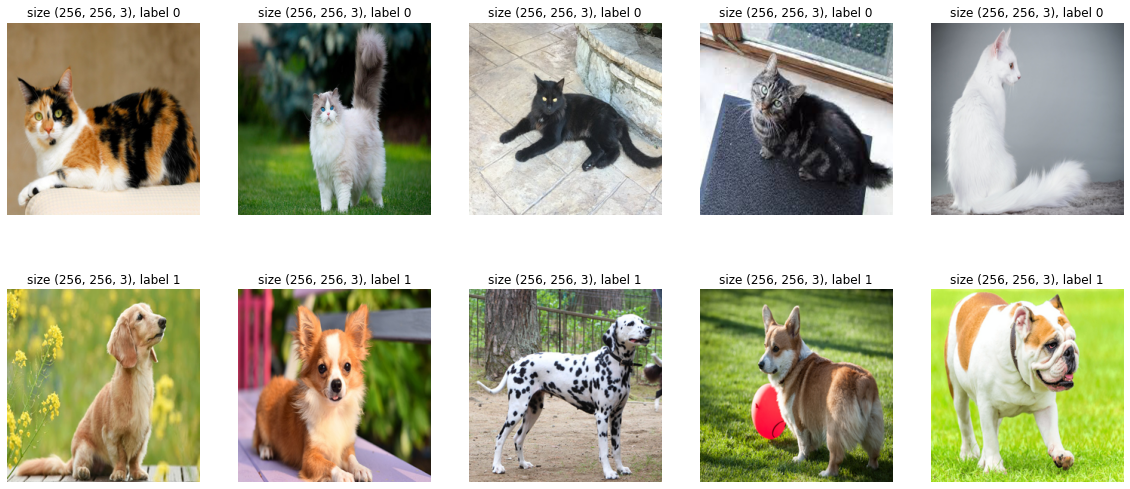

In [335]:
# 画像をリサイズ
dataset_resize = [np.array(image.resize((256,256))) for image in dataset]

fig = plt.figure(figsize=(20,9))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(dataset_resize[i])
    plt.axis('off')
    plt.title('size {}, label {}'.format(dataset_resize[i].shape, target[i]))

### PyTorch CNN 犬猫2値分類

In [250]:
import time
from tqdm import tqdm
import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

In [336]:
# 画像をfloatに変換
X = np.array(dataset_resize).astype('float32')
# 画像を正規化[0,1]
X /= 255 
# X = (X - 127.5) / 127.5 # 正則化[-1, 1]
# ラベルを数値型に変換し
y = np.array(target).astype(np.int)
# tensorの形を整える
X = X.reshape(10,3,256,256) # NCHW
y = y[:, None]

In [149]:
from sklearn.model_selection import train_test_split
# trainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

# 入力データはfloat、ラベルはlong（int）に変換
X_train = torch.from_numpy(X_train).float(); X_val = torch.from_numpy(X_val).float()

y_train = torch.from_numpy(y_train).float(); y_val = torch.from_numpy(y_val).float()

train_set = TensorDataset(X_train, y_train); val_set = TensorDataset(X_val, y_val)

In [132]:
class CNN(torch.nn.Module):
    
    def __init__(self, num_classes=1):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3), # out(8,254,254)
            nn.MaxPool2d((3,3), padding=1)) # out(8,85,85)
        self.l2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3), # out(16,83,83)
            nn.MaxPool2d((3,3), padding=1)) # out(16,28,28)
        self.l3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # out(16,26,26)
            nn.MaxPool2d((3,3), padding=1)) # out(32,9,9)
        self.lo = nn.Sequential(
            nn.Flatten(),  # out(2592)
            nn.Linear(2592, num_classes),
            nn.Sigmoid())
        
    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = F.relu(self.l3(h))
        out = self.lo(h)
        return out

In [150]:
model = CNN()
N_EPOCHS = 100
LR = 0.01
N_BATCH = 1

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR)


# 学習
model.train()
train_loader = DataLoader(train_set, batch_size=N_BATCH, shuffle=True)
total_step = len(train_loader)
start = time.time()
for epoch in range(N_EPOCHS):
    for samples, labels in train_loader:

        samples = torch.autograd.Variable(samples)
        labels = torch.autograd.Variable(labels)

        optimizer.zero_grad()  # 勾配の初期化
        outputs = model(samples)  # 出力計算
        loss = criterion(outputs, labels)  # ロス計算
        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータ更新
        
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, N_EPOCHS, loss.item()))

# 推定
total, tp = 0, 0
test_loader = DataLoader(val_set, batch_size=N_BATCH, shuffle=False)
model.eval()
for sample, label in test_loader:
    samples = torch.autograd.Variable(samples)
    labels = torch.autograd.Variable(labels)

    outputs = model(samples)
    preds = torch.eq(torch.sign(labels-0.5), torch.sign(outputs-0.5))        
    total += label.shape[0]
    tp += sum(preds)

acc = int(tp/total)
end = time.time()

print('val acc: {:.4f}'.format(acc))
print('\n wall time: {:.4f}sec'.format(end-start))

Epoch [10/100], Loss: 0.5910
Epoch [20/100], Loss: 0.7246
Epoch [30/100], Loss: 0.6905
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.6906
Epoch [60/100], Loss: 0.6999
Epoch [70/100], Loss: 0.7003
Epoch [80/100], Loss: 0.6792
Epoch [90/100], Loss: 0.6816
Epoch [100/100], Loss: 0.7028
val acc: 0.0000

 wall time: 10.4570sec


### Kerasも同様に学習実施

In [140]:
import time
import tensorflow as tf
from tensorflow.keras import backend as K

In [141]:
X = X.reshape(10,256,256,3) # NHWC

# trainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [142]:
K.clear_session()

input_data = tf.keras.layers.Input(shape=(256,256,3))  # channels last

l = tf.keras.layers.Conv2D(8, (3,3), padding='valid', activation=tf.nn.relu)(input_data)
l = tf.keras.layers.MaxPool2D((3,3), padding='same')(l)
l = tf.keras.layers.Conv2D(16, (3,3), padding='valid', activation=tf.nn.relu)(l)
l = tf.keras.layers.MaxPool2D((3,3), padding='same')(l)
l = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation=tf.nn.relu)(l)
l = tf.keras.layers.MaxPool2D((3,3), padding='same')(l)
l = tf.keras.layers.Flatten()(l)
output = tf.keras.layers.Dense(1, activation=tf.nn.softmax)(l)

model = tf.keras.Model(input_data, output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 83, 83, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0     

In [146]:
start = time.time()
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=100,
                    verbose=0,
                    validation_data=(X_val, y_val))
end = time.time()
print('wall time: {:.4f}sec'.format(end-start))

score = model.evaluate(X_val, y_val, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

wall time: 16.5800sec

Test loss: 7.666619300842285
Test accuracy: 0.5


>両モデルとも学習精度は最悪だが、PyTorchの方が計算早いため、今回はPyTorchモデルを採用

## 【問題2】分類データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。<br>
<br>
**《データ拡張のためのライブラリ》**<br>
<br>
データ拡張にはalbumentationsなどがあります。<br>
<br>
[albu/albumentations: fast image augmentation library and easy to use wrapper around other libraries](https://github.com/albumentations-team/albumentations)

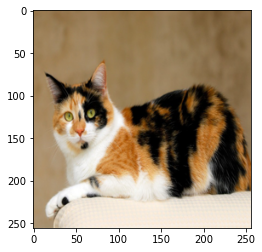

In [168]:
# 元の画像を描画
import cv2
from torch.utils.data import Dataset
import albumentations as albu

img = dataset_resize[0]
plt.imshow(img)

In [171]:
# 拡張用関数を定義
def augment(aug, image):
    return aug(image=image)['image']

### 拡張をいくつか試す

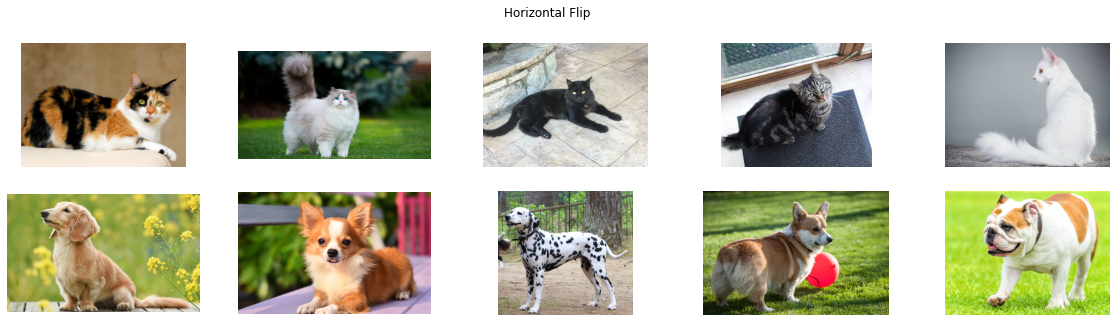

In [177]:
aug = albu.HorizontalFlip(p=1)

fig = plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(augment(aug, np.array(dataset[i])))
    plt.axis('off')
    fig.suptitle('Horizontal Flip')

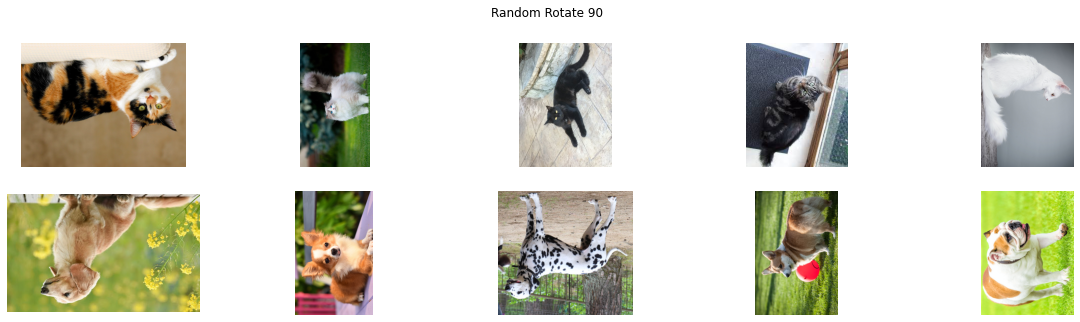

In [197]:
aug = albu.RandomRotate90(p=1)

fig = plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(augment(aug, np.array(dataset[i])))
    plt.axis('off')
    fig.suptitle('Random Rotate 90')

### 公式文書にあったランダムに拡張を実行するコードを実装

In [640]:
from albumentations import (
    Resize, HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

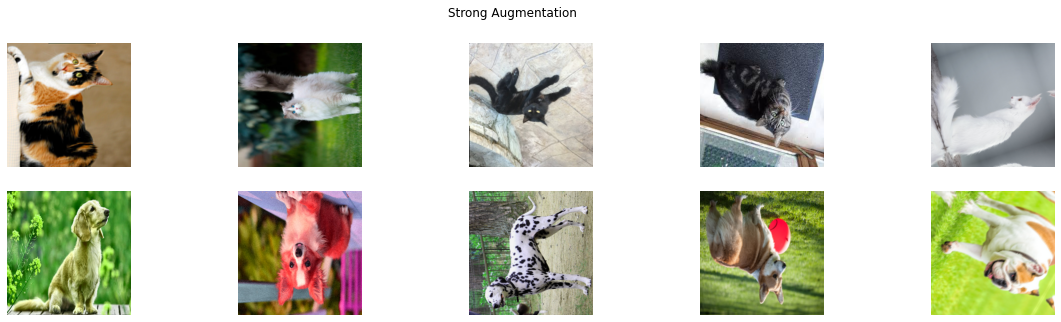

In [459]:
fig = plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(strong_aug(p=1)(image=dataset_resize[i])['image'])
    plt.axis('off')
    fig.suptitle('Strong Augmentation')

### データを水増しし、学習の準備を行う

In [445]:
# Resize後にaugmentを実行
dataset_aug = []
target_aug = []

SAMPLES = 1000 # データの総数を指定（元の画像の数が同じになるよう調整）

for i, img in enumerate(dataset_resize):
    for _ in range(int(SAMPLES/10)):
        aug_img = strong_aug(p=1)(image=img)['image']
        dataset_aug.append(aug_img)
        
        target_aug.append(target[i])

print(np.array(dataset_aug).shape)
print(np.array(target_aug).shape)

(1000, 256, 256, 3)
(1000,)


In [446]:
X = np.array(dataset_aug)
y = np.array(target_aug)
# 画像を正規化[0,1]
X = X / 255 
# X = (X - 127.5) / 127.5 # 正則化[-1, 1]
# tensorの形を整える
X = np.transpose(X, (0,3,1,2)) # NCHW
y = y[:, None]

In [447]:
# trainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

# 入力データとラベルをfloatに変換
X_train = torch.from_numpy(X_train).float(); X_val = torch.from_numpy(X_val).float()

y_train = torch.from_numpy(y_train).float(); y_val = torch.from_numpy(y_val).float()

train_set = TensorDataset(X_train, y_train); val_set = TensorDataset(X_val, y_val)

In [449]:
model = CNN()
N_EPOCHS = 100
LR = 0.01
N_BATCH = 20

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR)

train_loss = []

# 学習
model.train()
train_loader = DataLoader(train_set, batch_size=N_BATCH, shuffle=True)
total_step = len(train_loader)
start = time.time()
for epoch in range(N_EPOCHS):
    for samples, labels in train_loader:

        samples = torch.autograd.Variable(samples)
        labels = torch.autograd.Variable(labels)

        optimizer.zero_grad()  # 勾配の初期化
        outputs = model(samples)  # 出力計算
        loss = criterion(outputs, labels)  # ロス計算
        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータ更新
        
        train_loss.append(loss.item())
        
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, N_EPOCHS, loss.item()))

# 推定
total, tp = 0, 0
test_loader = DataLoader(val_set, batch_size=N_BATCH, shuffle=False)
model.eval()
for sample, label in test_loader:
    samples = torch.autograd.Variable(samples)
    labels = torch.autograd.Variable(labels)

    outputs = model(samples)
    preds = torch.eq(torch.sign(labels-0.5), torch.sign(outputs-0.5))        
    total += label.shape[0]
    tp += sum(preds)

acc = int(tp/total)
end = time.time()

print('val acc: {:.4f}'.format(acc))
print('\n wall time: {:.4f}sec'.format(end-start))

Epoch [10/100], Loss: 0.2770
Epoch [20/100], Loss: 0.0151
Epoch [30/100], Loss: 0.0121
Epoch [40/100], Loss: 0.0004
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
val acc: 1.0000

 wall time: 1132.1730sec


>同モデル・パラメータ環境において、データ水増しによって学習に成功した。

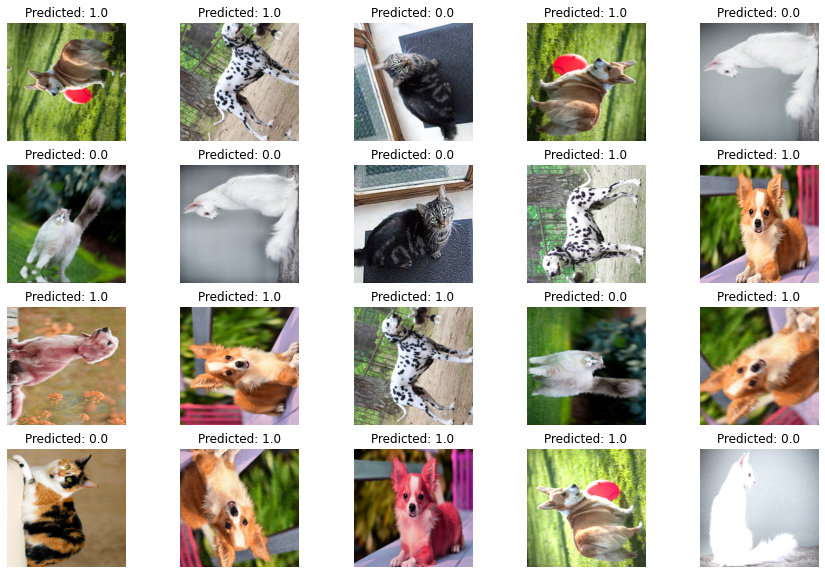

In [451]:
%matplotlib inline

# 推定を可視化
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = model(images)
predicted = torch.round(outputs)

fig = plt.figure(figsize=(15,10))

for i, image in enumerate(images):
    grid_img = torchvision.utils.make_grid((image*255).int())
    plt.subplot(4, 5, i+1)
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off')
    plt.title('Predicted: {}'.format(predicted[i].item()))

### Testデータに対する検証

In [393]:
testset = []

BASE_PATH = '/Users/tamiyagt/Documents/Machine Learning/01_github/diveintocode-ml/sprint/sprint18_dataset/test/'
for image in os.listdir(BASE_PATH):
    if '.jpg' in image:
        im = PIL.Image.open(BASE_PATH+image)
        im_rgb = im.convert('RGB')
        testset.append(im_rgb)

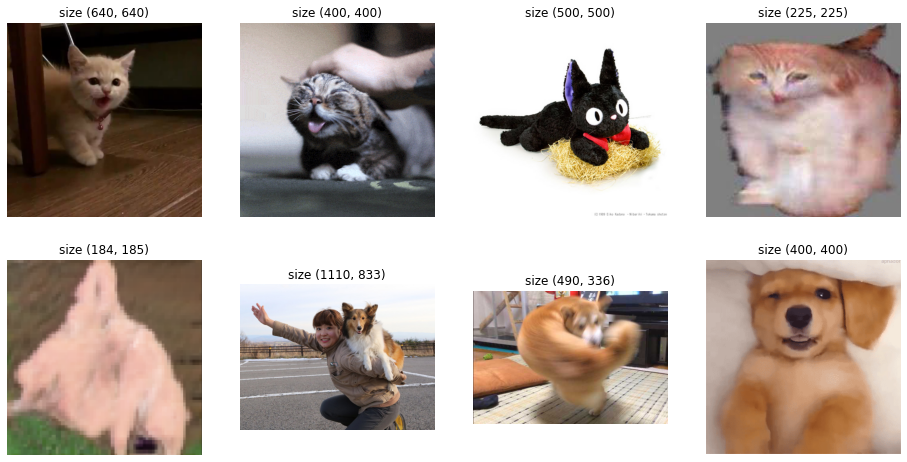

In [382]:
# Testデータを可視化
fig = plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(testset[i])
    plt.axis('off')
    plt.title('size {}'.format(testset[i].size))

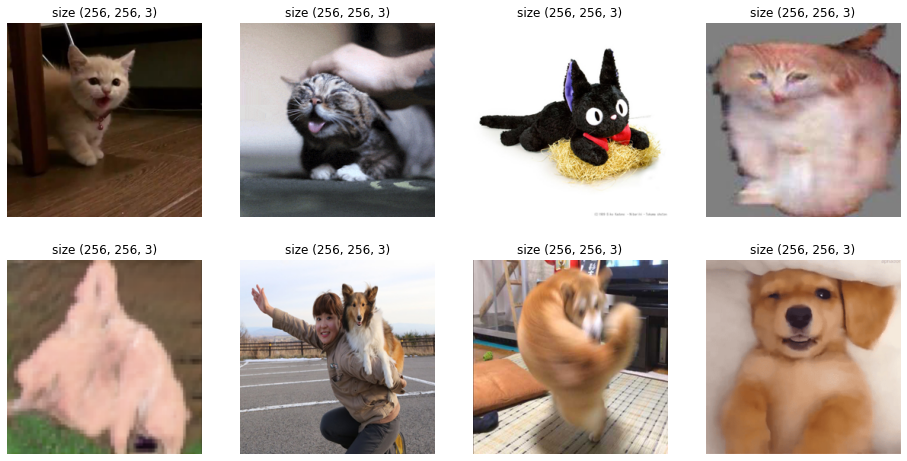

In [394]:
# 画像をリサイズ
testset_resize = [np.array(image.resize((256,256))) for image in testset]

fig = plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(testset_resize[i])
    plt.axis('off')
    plt.title('size {}'.format(testset_resize[i].shape))

In [405]:
X_test = np.array(testset_resize)
# 画像を正規化[0,1]
X_test = X_test / 255 
# X = (X - 127.5) / 127.5 # 正則化[-1, 1]
# tensorの形を整える
X_test = np.transpose(X_test, (0,3,1,2)) # NCHW

In [407]:
# floatに変換
X_test = torch.from_numpy(X_test).float()
test_set = TensorDataset(X_test)

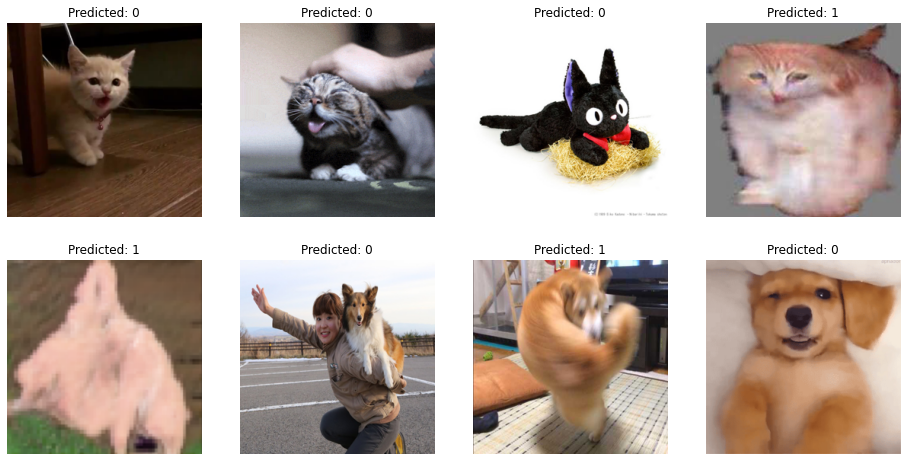

In [458]:
# 推定を可視化
model.eval()

fig = plt.figure(figsize=(16,8))

for i, image in enumerate(X_test):
    grid_img = torchvision.utils.make_grid((image*255).int())
    
    image = torch.autograd.Variable(image[None,:,:,:])
    outputs = model(image)
    predicted = torch.round(outputs)

    plt.subplot(2, 4, i+1)
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off')
    plt.title('Predicted: {}'.format(int(predicted.item())))

> 8枚中5枚を正しく推定できた。

## 【問題3】物体検出データセットの用意
次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。<br>
<br>
**《アノテーションのためのツール》**<br>
<br>
アノテーションツールにはLabelImgなどがあります。<br>
<br>
[tzutalin/labelImg: LabelImg is a graphical image annotation tool and label object bounding boxes in images](https://github.com/tzutalin/labelImg)

In [366]:
# アノテーションファイルのパスを指定
ANOT_PATH = '/Users/tamiyagt/Documents/Machine Learning/01_github/diveintocode-ml/sprint/sprint18_dataset/annotations/'
CLASS_PATH = '/Users/tamiyagt/Documents/Machine Learning/01_github/diveintocode-ml/sprint/sprint18_dataset/'

# labellmgの出力フォーマットを確認
print(np.loadtxt(ANOT_PATH+'dog_1.txt', dtype=str)) # [class, bounding box coord]
        
# ClassesはYOLO標準ファイルに犬猫があったため、流用（dog=0, cat=2）
classes = np.loadtxt(CLASS_PATH+'classes.txt', dtype=str, delimiter='/n')
print(classes)

['0' '0.490625' '0.550882' '0.918750' '0.849389']
['dog' 'person' 'cat' 'tv' 'car' 'meatballs' 'marinara sauce'
 'tomato soup' 'chicken noodle soup' 'french onion soup' 'chicken breast'
 'ribs' 'pulled pork' 'hamburger' 'cavity']


In [490]:
# yolo用アノテーションファイルを準備
# 各text fileをyolo形式で一つのファイルに保存 → [file name, bounding box coord, class]

annotations = []
for file in os.listdir(ANOT_PATH):
    if '.txt' in file:
        txt = np.loadtxt(ANOT_PATH+file, dtype=str)
        txt[0:-1], txt[-1] = txt[1:], txt[0] # 要素の位置を入れ替え、classを末尾へ
        annotations.append([file.rstrip('.txt')+'.jpg', ','.join((txt))])

annotations = np.array(annotations)
np.savetxt(CLASS_PATH+'train.txt', annotations, fmt='%s %s')

## 【問題4】物体検出データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。前述のalbumentationsはバウンディングボックスを合わせての加工が可能です。詳細はREADME.mdを確認してください。<br>
<br>
物体検出の学習を行なうかどうかは任意とします。

In [641]:
# BBoxをターゲットできない拡張手法を除外

def strong_aug_bbcompat(p=0.5):
    return Compose([
        Resize(256, 256),
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
#             OpticalDistortion(p=0.3),
#             GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], bbox_params=albu.BboxParams(format='pascal_voc', label_fields=['category_id']))

In [612]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
#     plt.figure(figsize=(12, 12))
    plt.imshow(img)
    
    
def yolo_to_xywh(image, bbox):
    yolo_x, yolo_y, yolo_width, yolo_height = bbox
    image_height, image_width = image
    
    x_center = yolo_x * image_width
    y_center = yolo_y * image_height
    width = yolo_width * image_width
    height = yolo_height * image_height

    x_left = (yolo_x - yolo_width/2) * image_width
    y_top = (yolo_y - yolo_height/2) * image_height
    
    return x_left, y_top, width, height

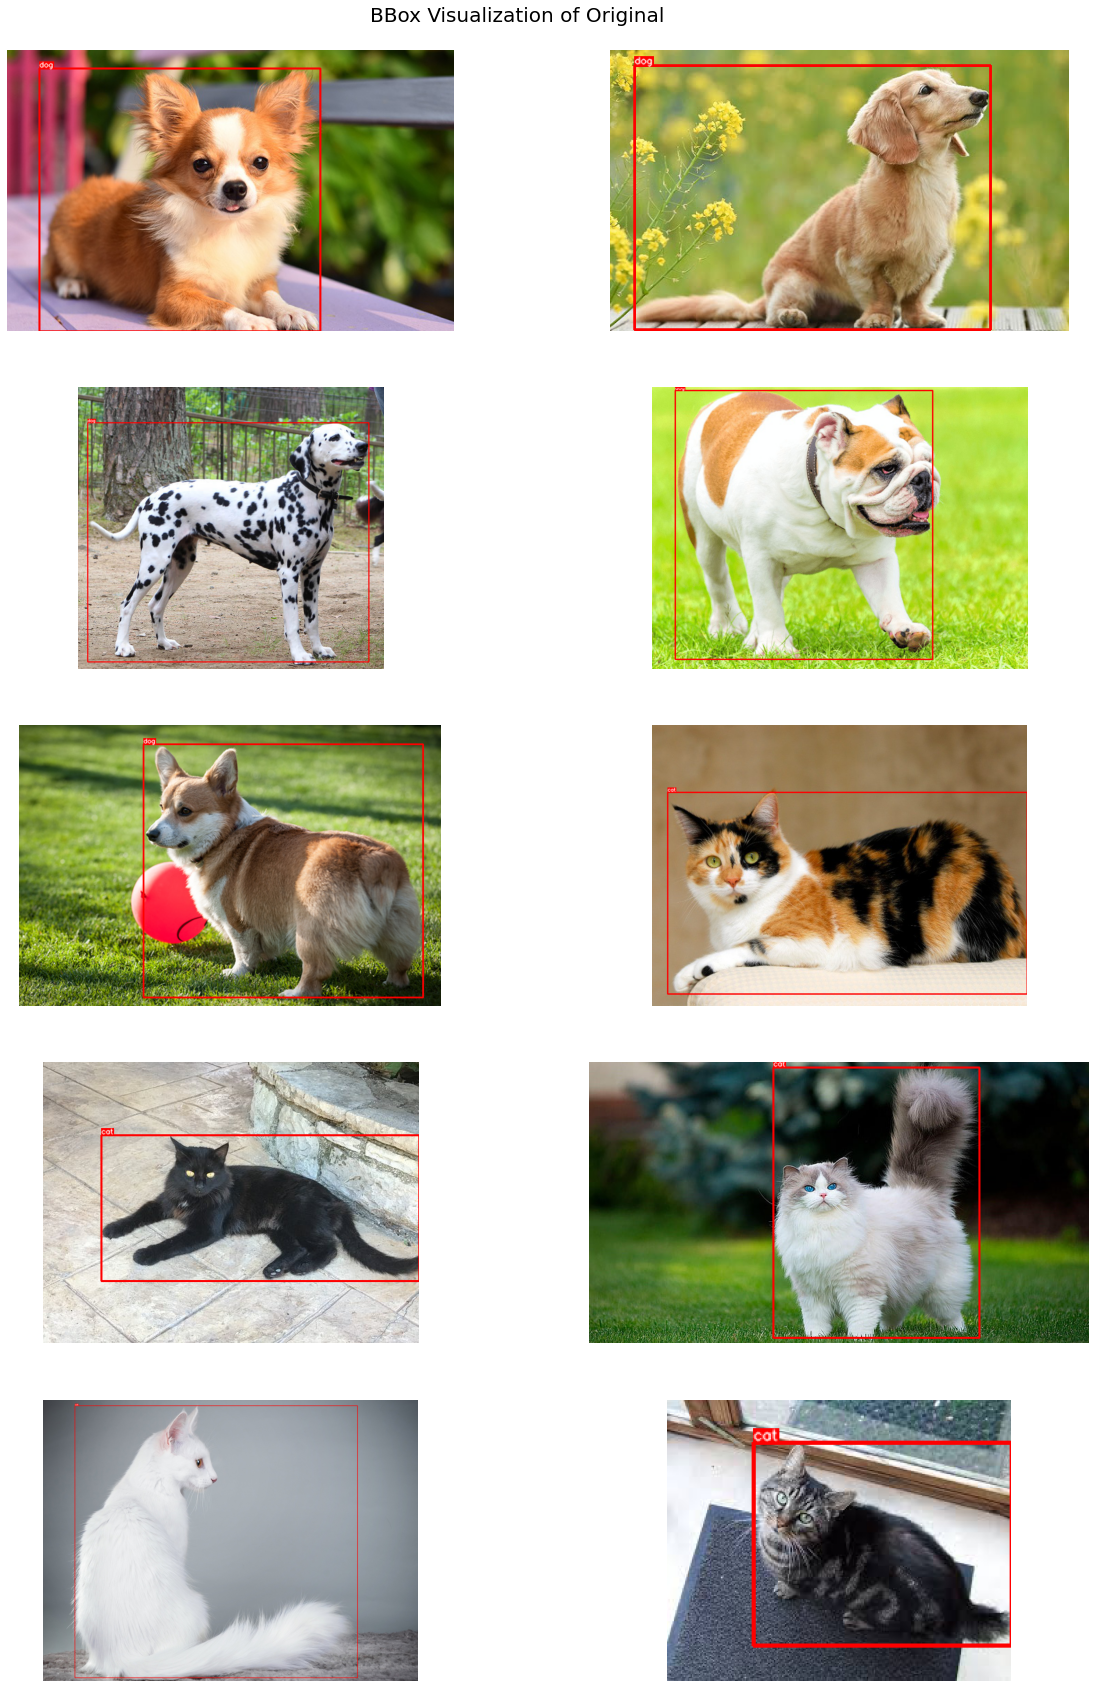

In [653]:
fig = plt.figure(figsize=(20,30))
for i, line in enumerate(annotations):
    image = PIL.Image.open(BASE_PATH+line[0]).convert('RGB')
    image = np.array(image)
    bbox_yolo = list(map(float, line[1].split(',')))[:-1]
    bbox = np.array(yolo_to_xywh(image.shape[:2], bbox_yolo))[None,:]
    category_id = [int(list(line[1].split(','))[-1])]
    
    anot_dic = {'image': image, 'bboxes': bbox, 'category_id': category_id}
    category_id_to_name={0: 'dog', 2: 'cat'}

    plt.subplot(5, 2, i+1)
    visualize(anot_dic, category_id_to_name)
    plt.axis('off')
    fig.suptitle('BBox Visualization of Original', fontsize=20, y=0.9)

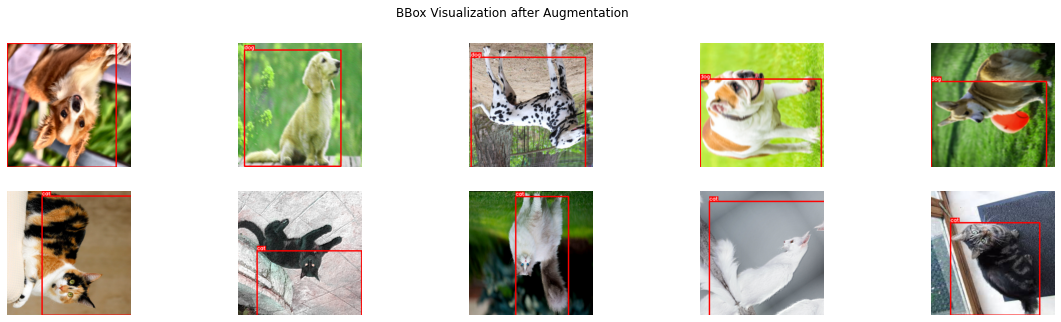

In [654]:
fig = plt.figure(figsize=(20,5))
for i, line in enumerate(annotations):
    image = PIL.Image.open(BASE_PATH+line[0]).convert('RGB')
    image = np.array(image)
    bbox_yolo = list(map(float, line[1].split(',')))[:-1]
    bbox = np.array(yolo_to_xywh(image.shape[:2], bbox_yolo))[None,:]
    category_id = [int(list(line[1].split(','))[-1])]
    
    anot_dic = {'image': image, 'bboxes': bbox, 'category_id': category_id}
    category_id_to_name={0: 'dog', 2: 'cat'}
    
    apply_aug = strong_aug_bbcompat(p=1)(**anot_dic)

    plt.subplot(2, 5, i+1)
    visualize(apply_aug, category_id_to_name)
    plt.axis('off')
    fig.suptitle('BBox Visualization after Augmentation')
    